We have 2 CASTLeS search queries:
* One with a 2.5 arcsecond radius 
* One with a 5 arcsecond radius
Visual inspection show that the 5 arcsecond ones is likely to have at least one star contaminant. 

However the main problematic, is likely due to Gaia xmatch errors. Lensed images that are close to each other let say 0.5 arcsecond are likely to have been treated as a single source, this data processing might have generated bias proper motion. 

A possible filtering is to not use known LQSO with size smaller than 0.6 arcsecond or better by checking the size between images (but I do not have this data in a table yet).

In [1]:
import os
import numpy as np
import pandas as pd

from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import NearestNeighbors
from sklearn import svm, tree

In [2]:
import matplotlib as mp
import matplotlib.pyplot as plt

In [3]:
mp.rcParams['figure.figsize'] = (12, 8)

In [21]:
import warnings
warnings.filterwarnings('ignore', category=Warning, append=True)
# read the Castle 2.5 xmatch with DR2
url1 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
d = Table.read(url1,format='votable').to_pandas()
d.qso_name = d.qso_name.str.decode('ascii')
print ("Total number of LQSO is {}".format(len(d)))

Total number of LQSO is 87


In [23]:
import warnings
warnings.filterwarnings('ignore', category=Warning, append=True)
# read the Castle 5 xmatch with DR2
url5 = 'http://vospace.esac.esa.int/vospace/sh/3ff8e13b3d12cce1a8d24448b77669865706268?dl=1'
d5 = Table.read(url5,format='votable').to_pandas()
d5.qso_name = d5.qso_name.str.decode('ascii')
print ("Total number of LQSO is {}".format(len(d5)))

Total number of LQSO is 115


In [86]:
def wrap180(x):
    """
    wrap longitudes defined on [0 360] degrees to radian defined on [-pi pi]
    why should I use the minus to get the LMC where I want?
    """
    return -Angle(x,unit=u.deg).wrap_at(180*u.deg).rad

def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error
    
parameters = ['x','y','dx','dy','xe','ye','dxe','dye','g','ge']

def getLQSO(d,name):
    """
    get the objects in the pandas dataframe d at an angular distance less than r arcsecond
    
    Since Gaia does not provide g mag error, I use quick approximation using the flux error... 
    maybe one should rather adapt the SIS code to use flux instead of magnitude
    
    d :  pandas data frame
    center : astropy skycoordinate
    r : radius in arcsecond
    """
    s = d[d.qso_name==name].copy()
    scale = u.deg.to(u.arcsecond)
    s['x'] = (s.ra - s.ra.median())*scale*np.cos(d.dec*u.deg.to(u.rad))
    s['y'] = (s.dec- s.dec.median())*scale
    
    s['xe']=s.ra_error*u.mas.to(u.arcsec)*np.cos(d.dec*u.deg.to(u.rad))
    s['ye']=s.dec_error*u.mas.to(u.arcsec)
    
    s['dx']= s.pmra
    s['dy']= s.pmdec
    s['dxe']=s.pmra_error
    s['dye']=s.pmdec_error
    s['g'] = s.phot_g_mean_mag
    s['ge'] = s.phot_g_mean_mag/s.phot_g_mean_flux_over_error
    return s


def plotGaiaLense(d,center,r=(-4,4),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    s = getLQSO(d,center)
    if(title=="") :
        title = center
    plotGaiaLense2(s,r=r,pm=pm,title=title)
    return s
    
def plotGaiaLense2(d,r=(-4,4),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    x = d.x
    y = d.y
    plt.errorbar(x,y,xerr=d.xe*1e3, yerr=d.ye*1e3,fmt='.')
    plt.scatter(x,y,s=100*np.exp(20-d.g),
                c=d.astrometric_pseudo_colour,vmin=1.2,vmax=2,cmap=mp.cm.coolwarm_r)
    plt.colorbar(label="astrometric pseudo color $[\mu m^{-1}]$")
    if pm : 
        vx = d.dx
        vy = d.dy
        plt.quiver(x,y, vx, vy, angles='xy', scale_units='xy', scale=1)
        plt.errorbar(x+vx,y+vy,xerr=d.dxe, yerr=d.dye,fmt='o')
    plt.grid()
    plt.xlabel("x [\"]")
    plt.ylabel("y [\"]")
    plt.title(title)
    plt.xlim(r[1],r[0])
    plt.ylim(r)

# CASTLeS catalogue

In [67]:
ls ../data

DR2simALLwiseQSO.csv  contaminantModel.csv  simDataSet0.csv.gzip
P2.csv                images/               simDataSet1.csv.gzip
castleDR2.csv         lensedQSO.csv


In [68]:
castles = pd.read_csv("../data/lensedQSO.csv",sep='\t',skipinitialspace=True)
castles.columns = ['#', 'Image', 'name', 'G', 'zs', 'zl', 'Ra', 'Dec',
       'Ext', 'ms', 'ml', 'FGHz', 'Nim', 'dl',
       'dt', 'sigma']

Text(0.5,0,'lens diameter  ["]')

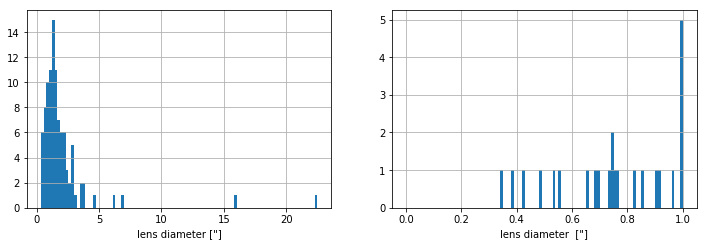

In [69]:
plt.subplot(221)
castles.dl.hist(bins=100)
plt.xlabel("lens diameter [\"]")
plt.subplot(222)
castles.dl.hist(bins=100,range=(0,1))
plt.xlabel("lens diameter  [\"]")

In [70]:
castles[castles.dl<0.6]

,#,Image,name,G,zs,zl,Ra,Dec,Ext,ms,ml,FGHz,Nim,dl,dt,sigma
4,5,NaN,B0128+437,B,3.124,NaN,01:31:13.405,+43:58:13.14,0.082,NaN,NaN,F5=48,4,0.55,NaN,NaN
8,9,NaN,B0218+357,A,0.96,0.68,02:21:05.483,+35:56:13.78,0.068,I=19.28/2,I=20.06,F5=1209,2ER,0.34,10.5±0.4,NaN
19,20,NaN,B0739+366,A,NaN,NaN,07:42:51.2,+36:34:43.7,0.076,I=25.25/2,I=21.91,F5=25,2,0.53,NaN,NaN
25,26,NaN,APM08279+5255,A,3.87,NaN,08:31:41.59,+52:45:17.0,0.050,I=14.55/3,NaN,NaN,3,0.38,NaN,NaN
54,55,NaN,Q1208+101,B,3.80,NaN,12:10:57.16,+09:54:25.6,0.022,I=16.96/2,NaN,NaN,2,0.48,NaN,NaN
73,74,NaN,B1555+375,A,NaN,NaN,15:57:11.93,+37:21:35.9,0.022,H=20.65/2,H=20.01,F5=35,4,0.42,NaN,NaN


# Analysis CASTLeS 2.5 vs CASTLeS 5

In [71]:
setMu(d)
setMu(d5)

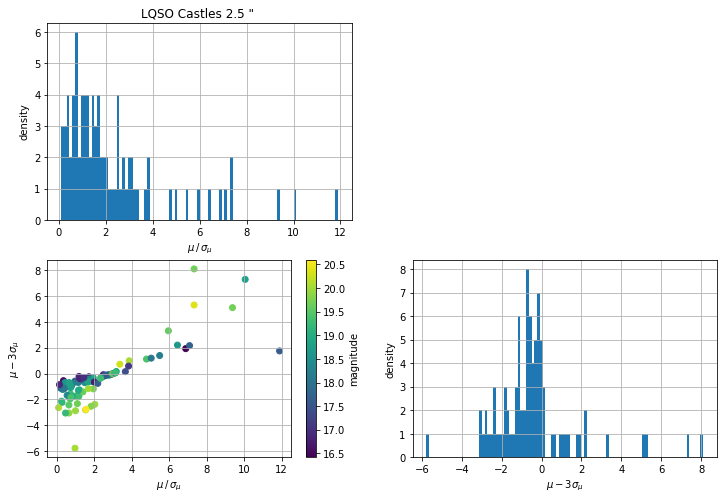

In [72]:
plt.subplot(221)
d.mu_over_error.hist(bins=100)
plt.title("LQSO Castles 2.5 \" ")
plt.ylabel("density")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")


plt.subplot(224)
(d.mu-3*d.mu_error).hist(bins=100)
plt.ylabel("density")
plt.xlabel("$\mu - 3  \sigma_{\mu}$")

plt.subplot(223)
plt.scatter(d.mu_over_error,(d.mu-3*d.mu_error),c=d.phot_g_mean_mag)
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")
plt.ylabel("$\mu - 3  \sigma_{\mu}$")
plt.colorbar(label="magnitude")
plt.grid()

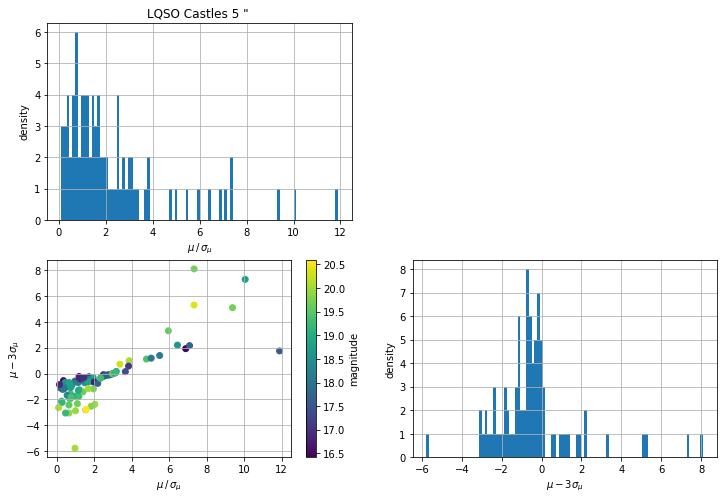

In [73]:
plt.subplot(221)
d5.mu_over_error.hist(bins=100)
plt.title("LQSO Castles 5 \" ")
plt.ylabel("density")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")


plt.subplot(224)
(d5.mu-3*d5.mu_error).hist(bins=100)
plt.ylabel("density")
plt.xlabel("$\mu - 3  \sigma_{\mu}$")

plt.subplot(223)
plt.scatter(d5.mu_over_error,(d5.mu-3*d5.mu_error),c=d5.phot_g_mean_mag)
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")
plt.ylabel("$\mu - 3  \sigma_{\mu}$")
plt.colorbar(label="magnitude")
plt.grid()

Text(0.5,0,'$\\mu \\, / \\, \\sigma_{\\mu}$')

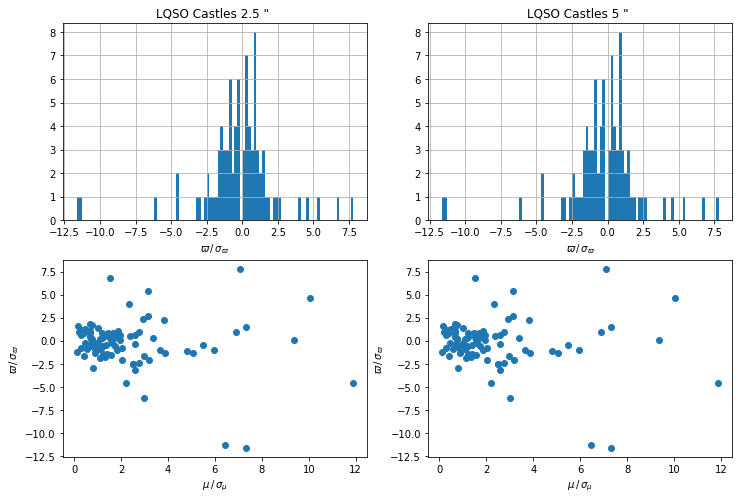

In [74]:
plt.subplot(221)
d.parallax_over_error.hist(bins=100)
plt.xlabel("$ \\varpi \, / \, \sigma_{\\varpi}$")
plt.title("LQSO Castles 2.5 \" ")

plt.subplot(223)
plt.scatter(d.mu_over_error,d.parallax_over_error)
plt.ylabel("$ \\varpi \, / \, \sigma_{\\varpi}$")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")


plt.subplot(222)
d5.parallax_over_error.hist(bins=100)
plt.xlabel("$ \\varpi \, / \, \sigma_{\\varpi}$")
plt.title("LQSO Castles 5 \" ")

plt.subplot(224)
plt.scatter(d5.mu_over_error,d5.parallax_over_error)
plt.ylabel("$ \\varpi \, / \, \sigma_{\\varpi}$")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")

# CASTLeS 5 "

In [75]:
d = d5

In [76]:
centers = d.groupby(d.qso_name)['ra','dec'].mean()
centers['coord'] = SkyCoord(centers.ra,centers.dec,unit='degree')
centers['mu_over_error'] = d.groupby(d.qso_name).mu_over_error.max()
centers = centers.reset_index()

In [77]:
centers.index

RangeIndex(start=0, stop=56, step=1)

In [78]:
len(centers)

56

out of 100 lensed QSO in Castles catalogue 51 have images in DR2 with a 2.5 search radius and 44 have at least one images with proper motion

out of 100 lensed QSO in Castles catalogue 56 have images in DR2 with a 5 search radius and 50 have at least one images with proper motion

In [79]:
print(len(centers),len(centers.dropna()))

56 50


In [80]:
len(centers[centers.mu_over_error>3])

17

In [81]:
qso_names =  d.qso_name.unique()

In [82]:
qso_names

array(['HE0047-1756', 'Q0142-100', 'QJ0158-4325', 'B0218+357',
       'HE0230-2130', 'SDSS0246-0825', 'HE0435-1223', 'HE0512-3329',
       'SDSS0746+4403', 'SDSS0806+2006', 'HS0810+2554', 'HS0818+1227',
       'APM08279+5255', 'SDSS0903+5028', 'RXJ0911+0551', 'SBS0909+523',
       'RXJ0921+4529', 'SDSS0924+0219', 'FBQ0951+2635', 'BRI0952-0115',
       'Q0957+561', 'SDSS1001+5027', 'SDSS1004+4112', 'LBQS1009-0252',
       'Q1017-207', 'SDSS1021+4913', 'B1030+074', 'HE1104-1805',
       'PG1115+080', 'RXJ1131-1231', 'SDSS1138+0314', 'SDSS1155+6346',
       'B1152+200', 'SDSS1206+4332', 'Q1208+101', 'SDSS1226-0006',
       'SDSS1332+0347', 'LBQS1333+0113', 'SDSS1353+1138', 'Q1355-2257',
       'SDSS1406+6126', 'H1413+117', 'B1422+231', 'SBS1520+530',
       'MG1549+3047', 'FBQ1633+3134', 'SDSS1650+4251', 'MG1654+1346',
       'PKS1830-211', 'PMNJ1838-3427', 'WFI2026-4536', 'WFI2033-4723',
       'B2108+213', 'HE2149-2745', 'Q2237+030', 'PSS2322+1944'],
      dtype=object)

In [83]:
HE0435 =  SkyCoord.from_name("HE0435-1223")

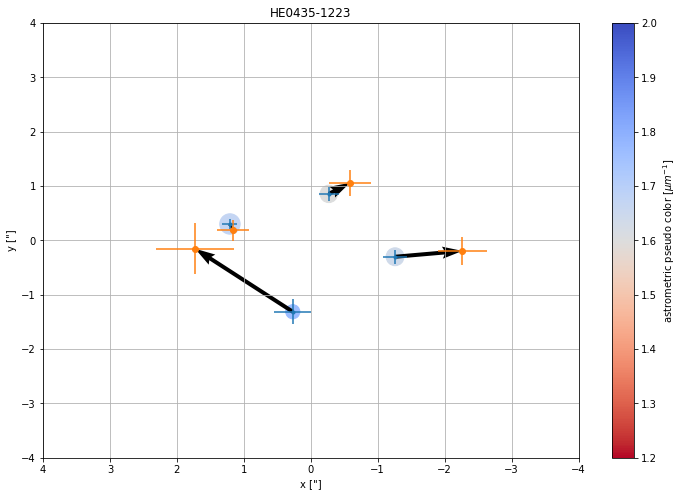

In [90]:
s = plotGaiaLense(d,"HE0435-1223")

In [94]:
s[['astrometric_pseudo_colour','phot_g_mean_mag','pmra','pmdec']]

,astrometric_pseudo_colour,phot_g_mean_mag,pmra,pmdec
7,1.799022,19.035519,0.346789,-0.795007
8,1.683959,19.304102,0.591246,0.993826
9,1.633056,20.065113,-0.549211,-4.363206


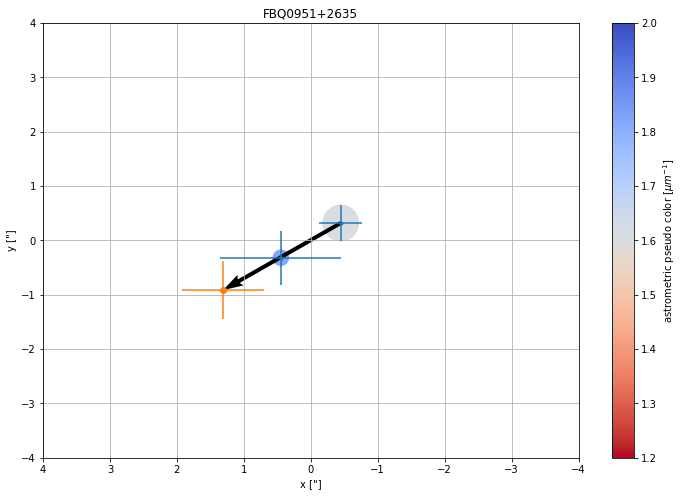

In [91]:
s = plotGaiaLense(d,"FBQ0951+2635")

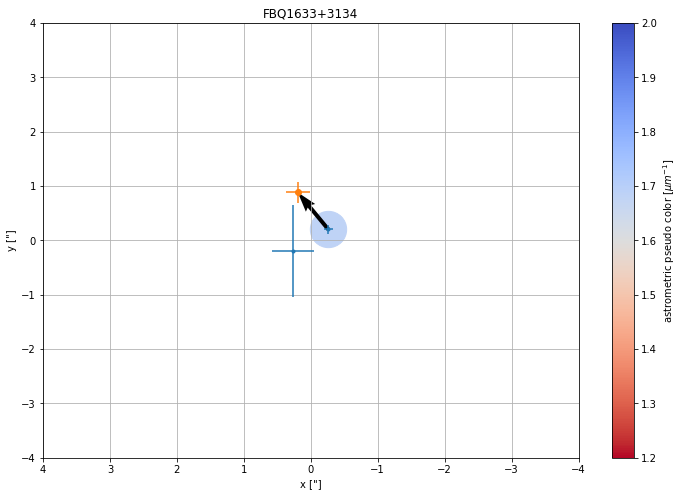

In [92]:
s = plotGaiaLense(d,"FBQ1633+3134")

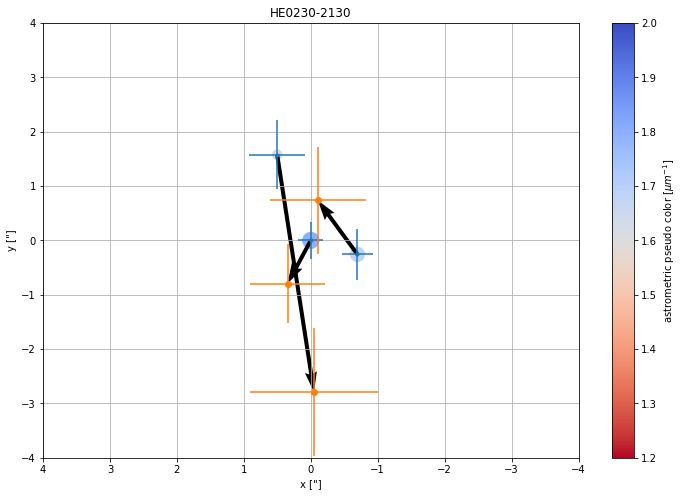

In [93]:
s = plotGaiaLense(d,"HE0230-2130")

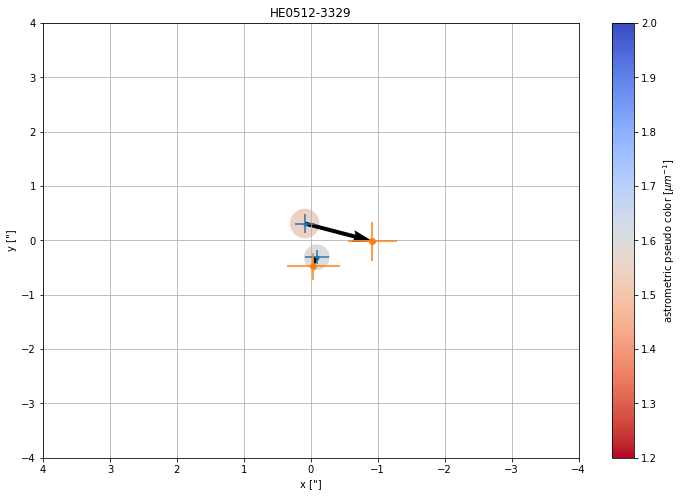

In [31]:
i=centers[centers.qso_name=="HE0512-3329"].index[0]
plotGaiaLense(d,centers.coord[i],title=centers.qso_name[i])

,qso_name,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,x,y,xe,ye,dx,dy,dxe,dye,g,ge
110,HE2149-2745,1.635721e+18,b'Gaia DR2 6810217624778074752',6.810218e+18,1.375262e+09,2015.5,328.031288,0.254860,-27.530174,0.230910,...,0.444840,0.722378,0.000226,0.000231,1.207476,0.073789,0.453196,0.390244,18.373522,0.135346
111,HE2149-2745,1.635721e+18,b'Gaia DR2 6810217556059370240',6.810218e+18,8.430891e+07,2015.5,328.031009,0.089684,-27.530575,0.083471,...,-0.444839,-0.722378,0.000080,0.000083,-0.228706,-0.178575,0.162899,0.140693,17.003477,0.103415


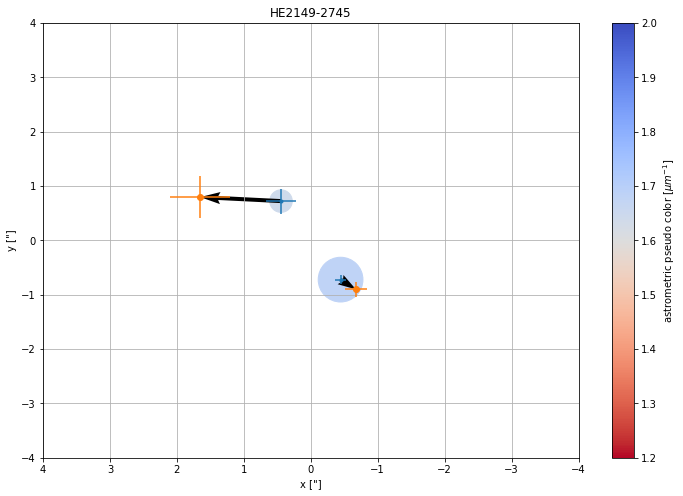

In [95]:
plotGaiaLense(d,"HE2149-2745")

,qso_name,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,x,y,xe,ye,dx,dy,dxe,dye,g,ge
55,PG1115+080,1.635721e+18,b'Gaia DR2 3817878828362669568',3.817879e+18,3.826219e+08,2015.5,169.570628,24.480528,7.766125,2.968428,...,0.666882,-0.258401,0.024256,0.002968,NaN,NaN,NaN,NaN,17.170164,0.173845
56,PG1115+080,1.635721e+18,b'Gaia DR2 3817878828361980544',3.817879e+18,1.427921e+08,2015.5,169.570667,0.324324,7.766250,0.319379,...,0.806240,0.192350,0.000321,0.000319,-2.138326,-1.559416,0.662190,0.480137,17.150152,0.231343
57,PG1115+080,1.635721e+18,b'Gaia DR2 3817878828361980160',3.817879e+18,3.052438e+08,2015.5,169.570158,0.437073,7.766143,0.288209,...,-1.009878,-0.192350,0.000433,0.000288,-0.276448,-0.779038,0.620356,0.618365,18.941341,0.189880
58,PG1115+080,1.635721e+18,b'Gaia DR2 3817878828361980288',3.817879e+18,1.549085e+09,2015.5,169.570254,0.315723,7.766688,0.187224,...,-0.666881,1.769788,0.000313,0.000187,0.150940,-0.008645,0.443610,0.330199,18.583698,0.120469


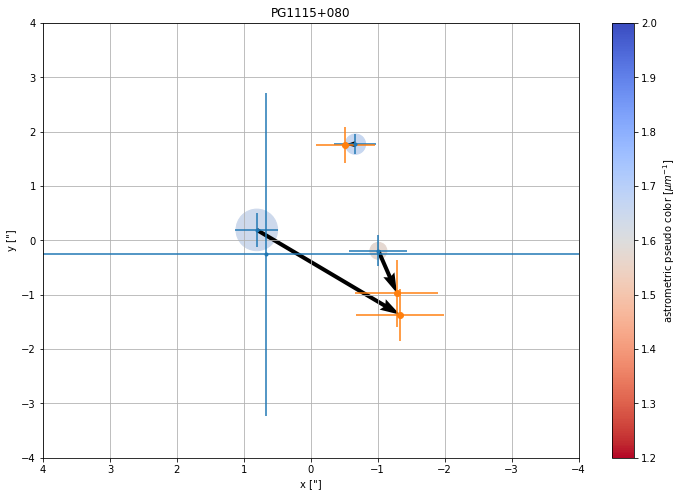

In [96]:
plotGaiaLense(d,"PG1115+080")

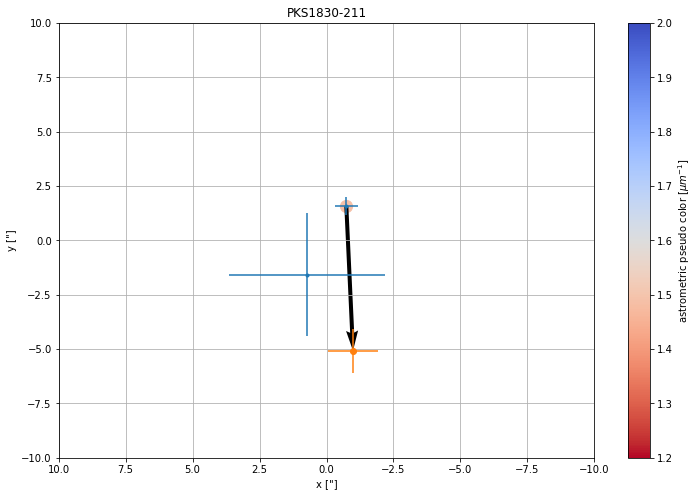

In [100]:
s = plotGaiaLense(d,"PKS1830-211",r=(-10,10))

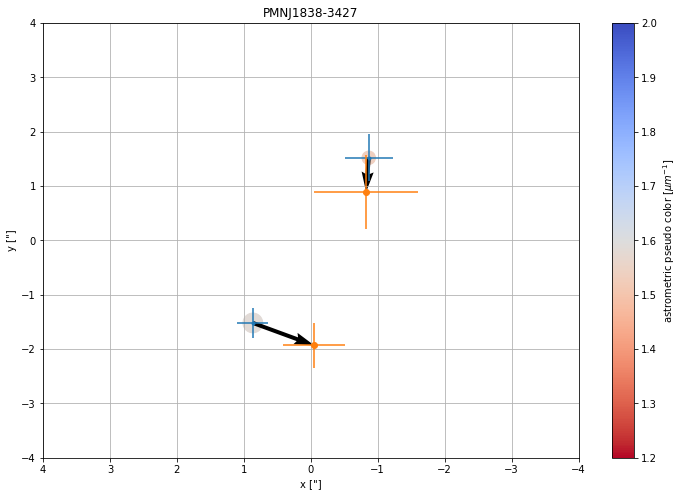

In [99]:
s = plotGaiaLense(d,"PMNJ1838-3427")

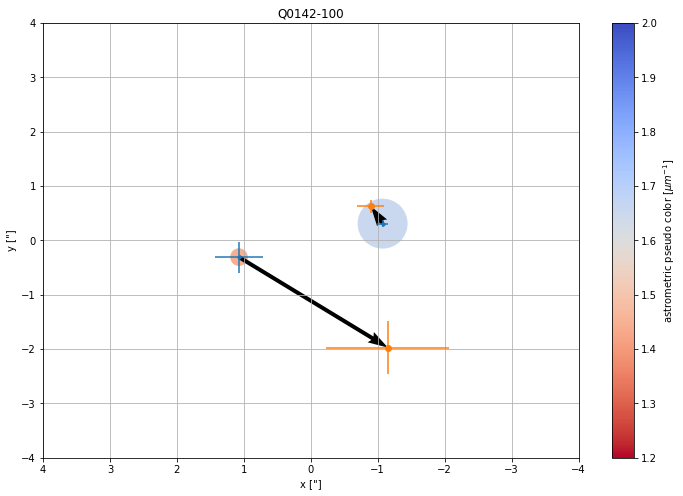

In [101]:
s= plotGaiaLense(d,"Q0142-100")

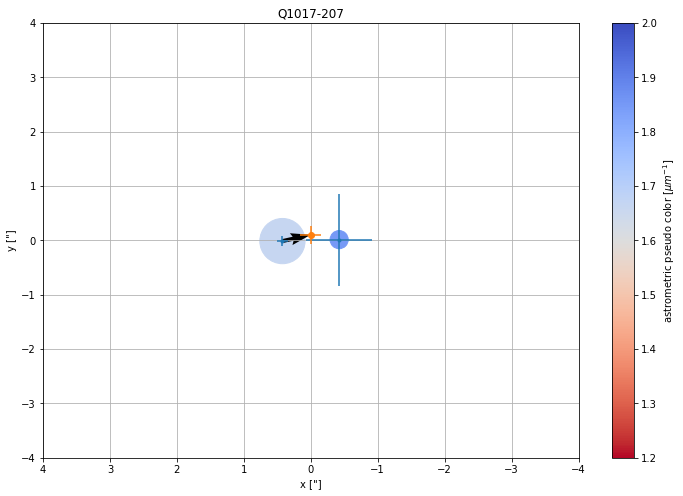

In [102]:
s=plotGaiaLense(d,"Q1017-207")

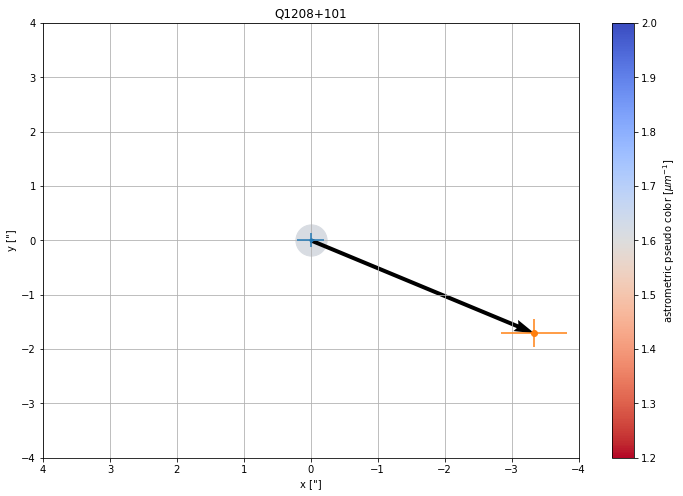

In [103]:
s = plotGaiaLense(d,"Q1208+101")

In [104]:
s[['qso_name','astrometric_pseudo_colour','phot_g_mean_mag','phot_g_mean_flux','phot_g_mean_flux_error','pmra','pmdec']]

,qso_name,astrometric_pseudo_colour,phot_g_mean_mag,phot_g_mean_flux,phot_g_mean_flux_error,pmra,pmdec
69,Q1208+101,1.613768,17.721266,1537.58752,6.753006,-3.338077,-1.707994


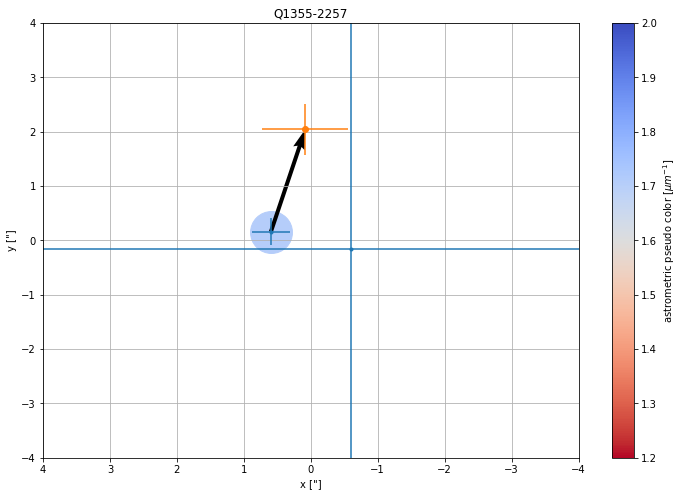

In [106]:
name="Q1355-2257"
s = plotGaiaLense(d,name)

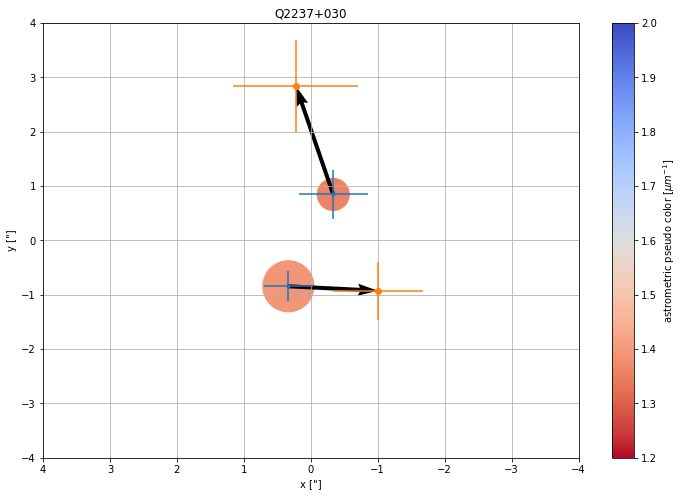

In [107]:
name="Q2237+030"
s = plotGaiaLense(d,name)

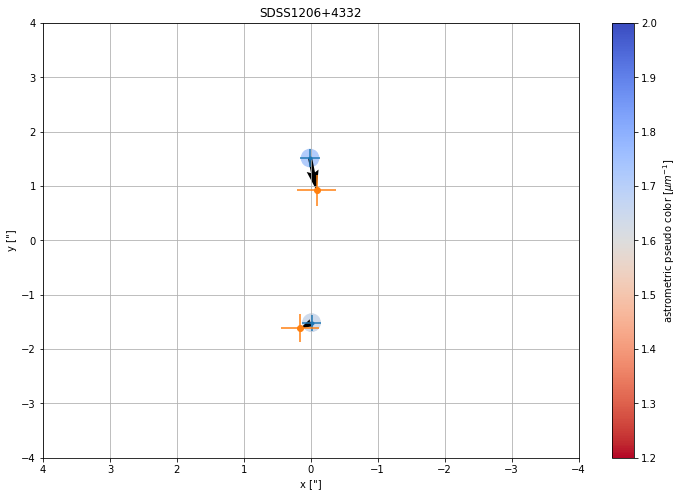

In [109]:
name = qso_names[33]
s = plotGaiaLense(d,name)

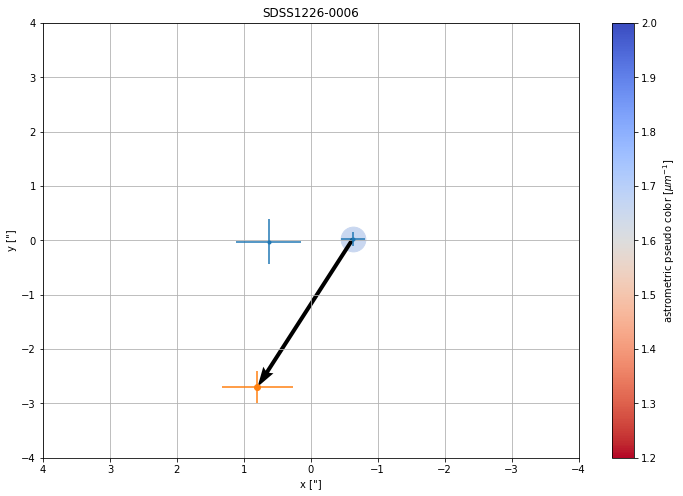

In [110]:
name = qso_names[35]
s = plotGaiaLense(d,name)

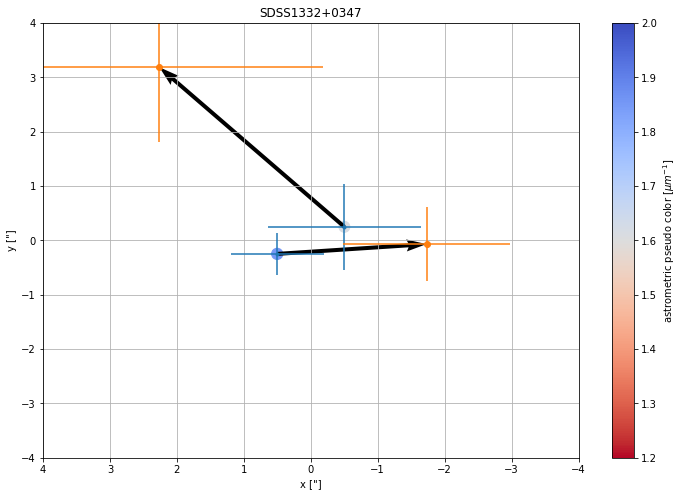

In [111]:
name = qso_names[36]
s = plotGaiaLense(d,name)

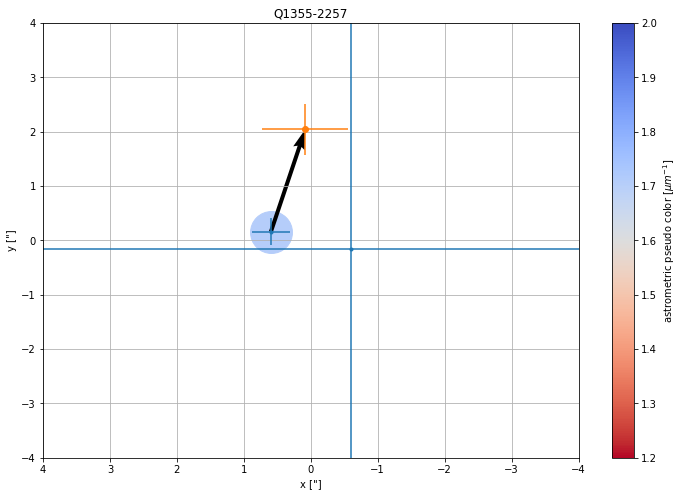

In [113]:
name = qso_names[39]
s = plotGaiaLense(d,name)

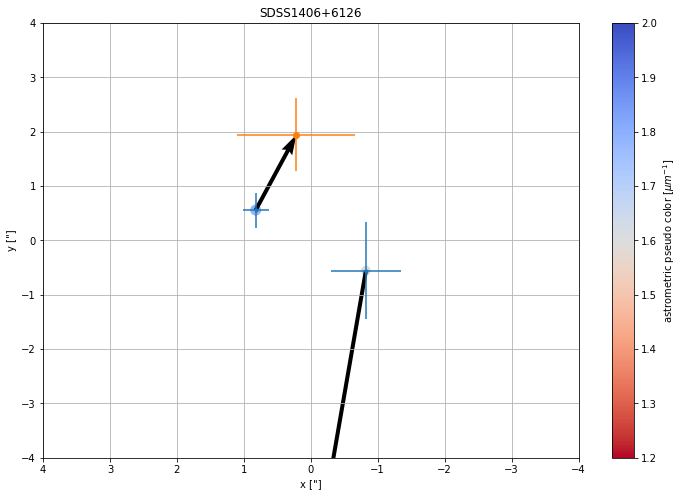

In [114]:
name = qso_names[40]
s = plotGaiaLense(d,name)

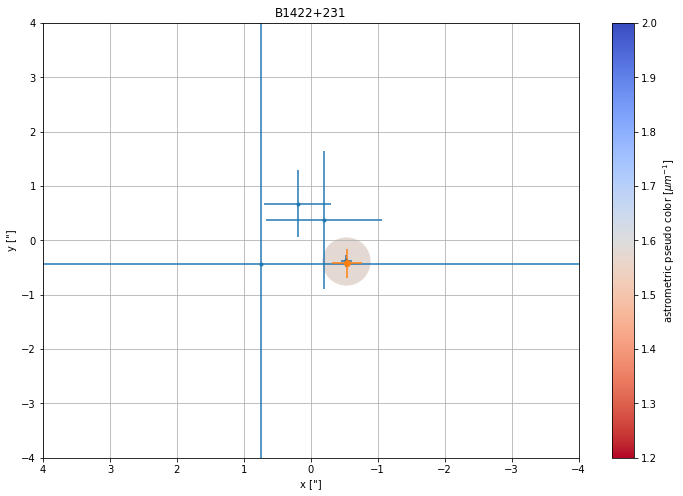

In [115]:
name = qso_names[42]
s = plotGaiaLense(d,name)

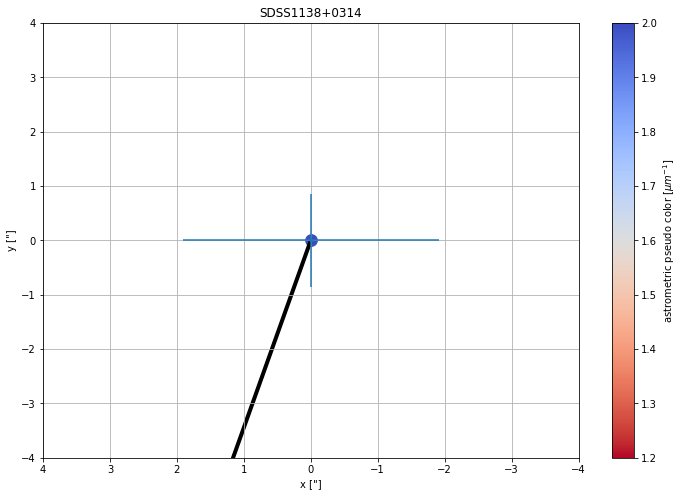

In [116]:
name = "SDSS1138+0314"
s = plotGaiaLense(d,name)

https://www.cfa.harvard.edu/castles/Individual/SDSS1226.html

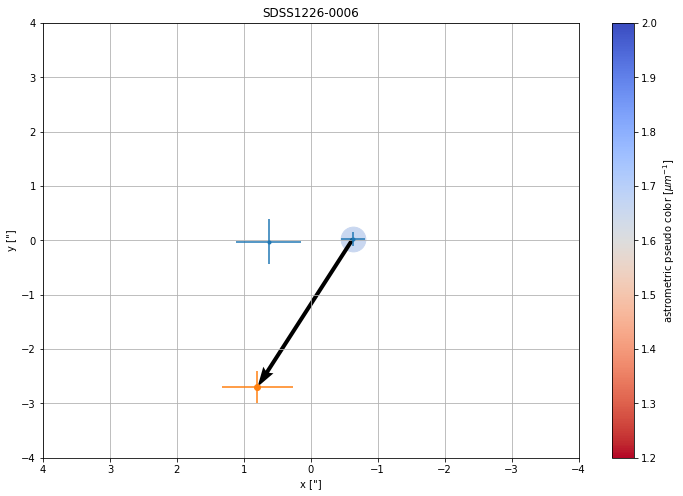

In [117]:
name = "SDSS1226-0006"
s = plotGaiaLense(d,name)

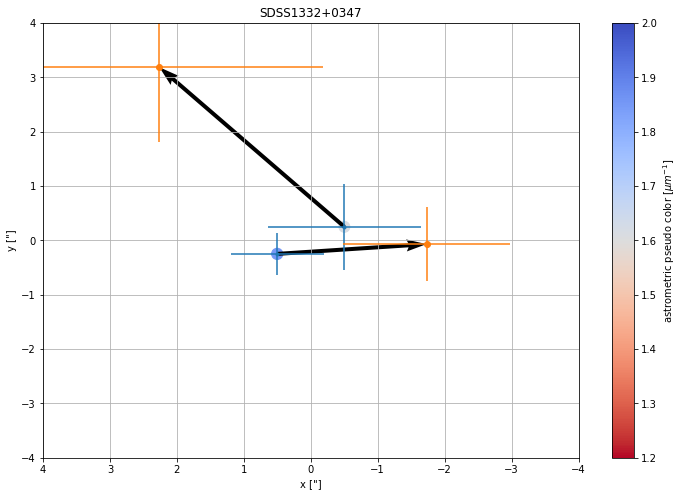

In [118]:
name = "SDSS1332+0347"
s = plotGaiaLense(d,name)

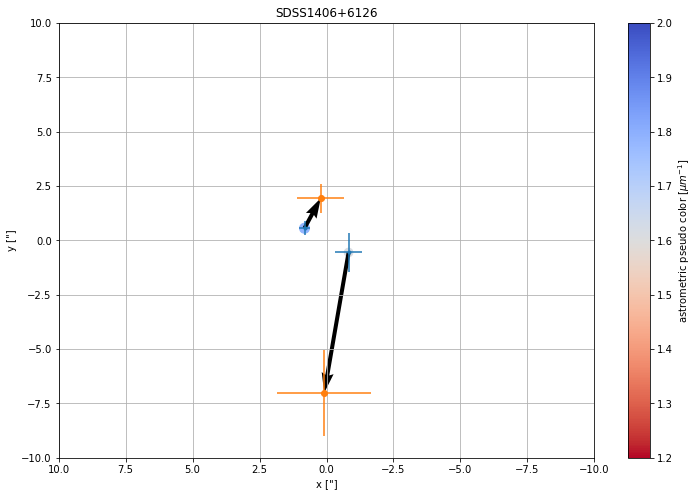

In [122]:
name = "SDSS1406+6126"
s = plotGaiaLense(d,name,r=(-10,10))

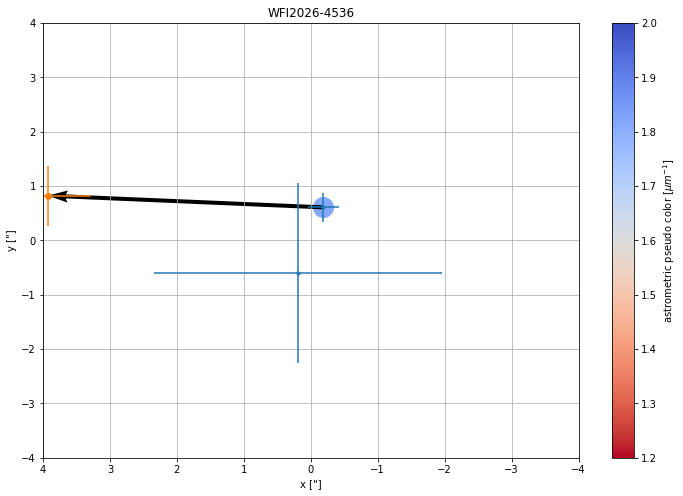

In [123]:
name = "WFI2026-4536"
s = plotGaiaLense(d,name)

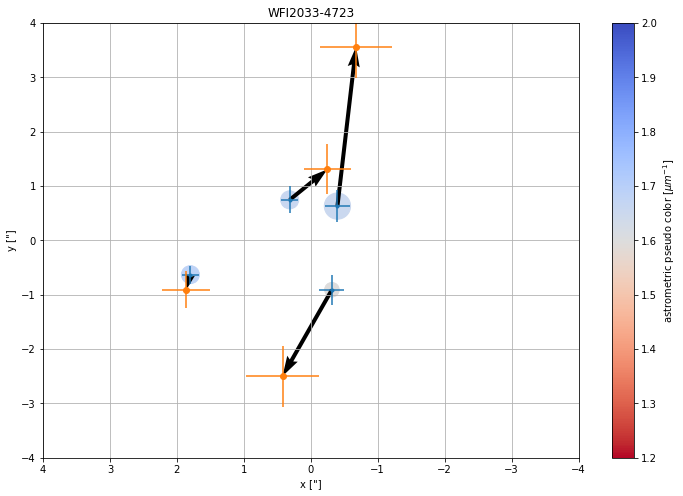

In [124]:
name = "WFI2033-4723"
s = plotGaiaLense(d,name)

An image was missing in CASTLeS 2.5

see https://www.cfa.harvard.edu/castles/Individual/WFI2033.html

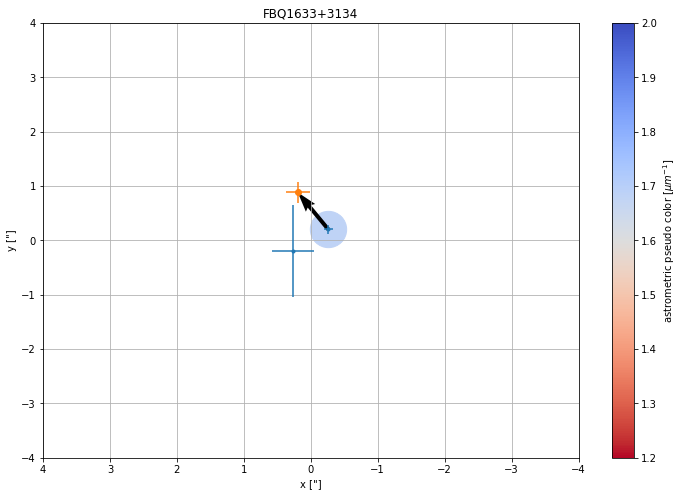

In [126]:
name='FBQ1633+3134'
s = plotGaiaLense(d,name)

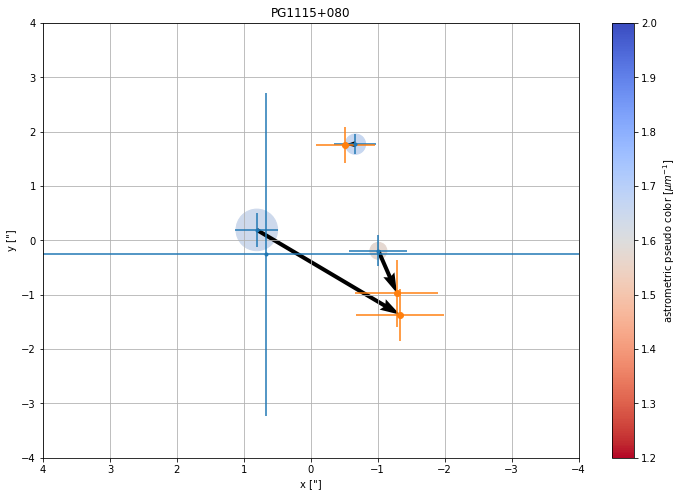

In [127]:
name='PG1115+080'
s = plotGaiaLense(d,name)

# Filtering

https://www.cfa.harvard.edu/castles/Individual/Q1208.html

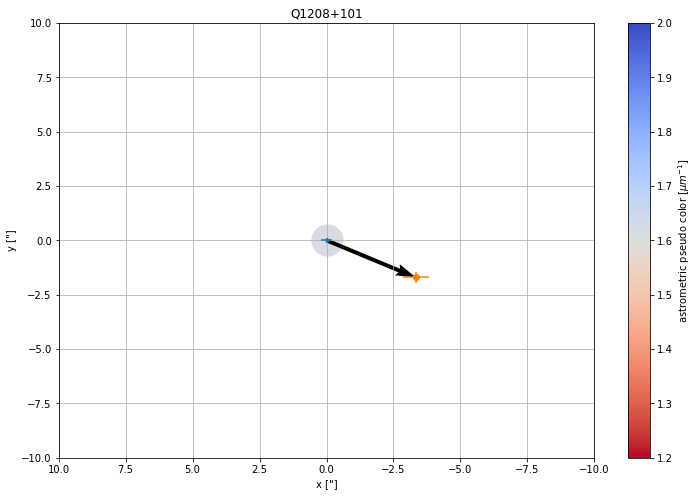

In [129]:
name="Q1208+101"
s = plotGaiaLense(d,name,r=(-10,10))

the proper motion of RXJ0911+0551 is corrupted in Gaia data processing, very likely Xmatch issue, only one instead of 2 images have been detected

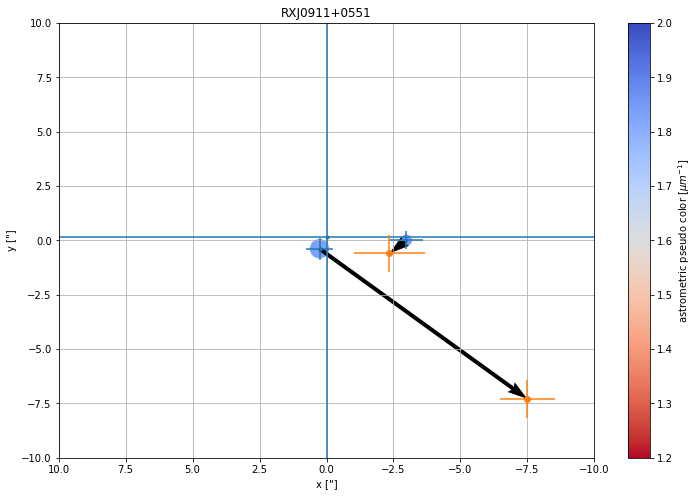

In [131]:
name="RXJ0911+0551"
s = plotGaiaLense(d,name,r=(-10,10))

see https://www.cfa.harvard.edu/castles/Individual/RXJ0911.html

a similar problem arise for SDSS1138, only one images is detected instead of 4

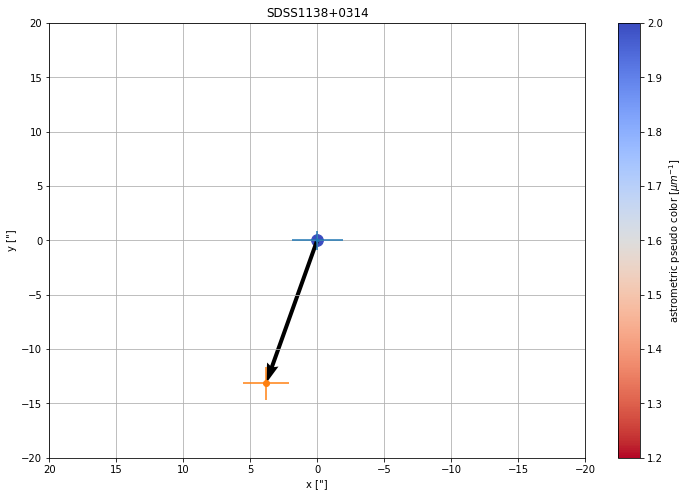

In [133]:
name="SDSS1138+0314"
s = plotGaiaLense(d,name,r=(-20,20))

see https://www.cfa.harvard.edu/castles/Individual/SDSS1138.html

the case of SBS1520+530 is different

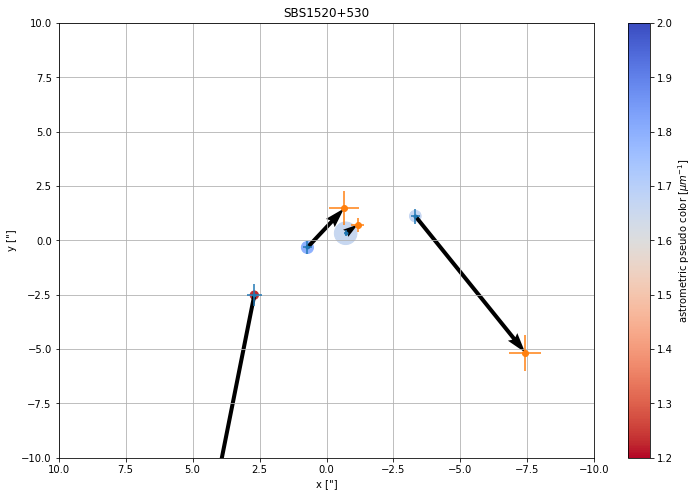

In [136]:
name="SBS1520+530"
s = plotGaiaLense(d,name,r=(-10,10))

see https://www.cfa.harvard.edu/castles/Individual/SBS1520.html

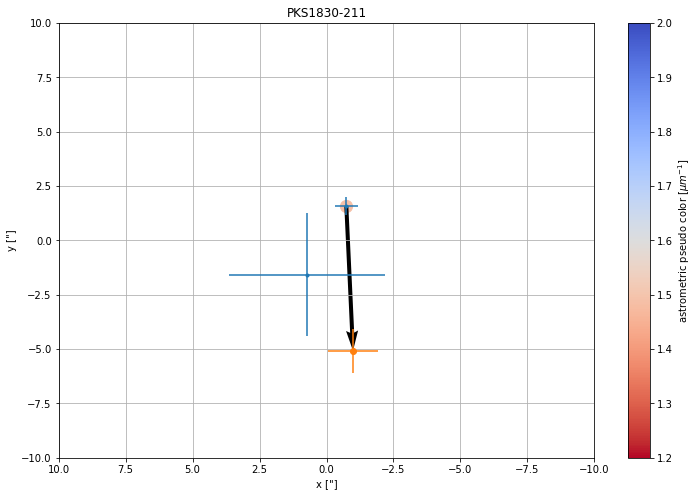

In [137]:
name="PKS1830-211"
s = plotGaiaLense(d,name,r=(-10,10))

see https://www.cfa.harvard.edu/castles/Individual/PKS1830.html